# House Prices - Advanced Regression Techniques 🏠

This notebook tackles the Kaggle competition: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview).

The goal is to predict the final sale prices of residential homes in Ames, Iowa, based on 79 features such as square footage, neighborhood, quality of materials, among others.

Given the large number of variables, a significant portion of the work involves handling missing data and performing feature engineering.

We use XGBoost to predict house prices on the test dataset, but first we go through the following steps:

- Transform response variable
- Include auxiliary information from the [Ames housing dataset](https://www.kaggle.com/datasets/shashanknecrophapa/ames-housing-dataset)
- Missing value treatment
- Feature engineering and transformation
- Encoding categorical variables
- Model training and prediction

In [100]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor, plot_importance
from sklearn.impute import SimpleImputer
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [3]:
# Function to print large datasets
def show_with_scroll(df, max_height=400, max_width=1000):
    display(HTML(
        df.to_html().replace(
            "<table",
            f'<div style="max-height:{max_height}px;max-width:{max_width}px;overflow:auto;"><table'
        ) + "</div>"
    ))

## Include auxiliar information

In this section, we will include auxiliary information from the [Ames housing dataset](https://www.kaggle.com/datasets/shashanknecrophapa/ames-housing-dataset). This will help us to have a better model for prediction.

In [5]:
# Import data
Train = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')
Ames = pd.read_csv('AmesHousing.csv')

print('Train:', Train.shape)
print('Test:', Test.shape)
print('Ames:', Ames.shape)

Train: (1460, 81)
Test: (1459, 80)
Ames: (2930, 82)


In [6]:
# To compare column names across the datasets
cols_dic = dict(Ames_cols= Ames.columns,
               Train_cols = Train.columns,
               Test_cols= Test.columns)
cols_df = pd.DataFrame.from_dict(cols_dic, orient='index').transpose()
cols_df

,Ames_cols,Train_cols,Test_cols
0,Order,Id,Id
1,PID,MSSubClass,MSSubClass
2,MS SubClass,MSZoning,MSZoning
3,MS Zoning,LotFrontage,LotFrontage
4,Lot Frontage,LotArea,LotArea
...,...,...,...
77,Mo Sold,YrSold,YrSold
78,Yr Sold,SaleType,SaleType
79,Sale Type,SaleCondition,SaleCondition
80,Sale Condition,SalePrice,None


In [7]:
# Drops redundant index-like columns or unnecessary identifiers
Ames = Ames.drop(['Order', 'PID'], axis = 1)
Train = Train.drop('Id', axis = 1)

In [8]:
# Build Column Mapping Between Ames and Train
cols_dic = dict(zip(Ames.columns, Train.columns))

In [9]:
# Rename columns of Ames using Train’s naming
Ames = Ames.rename(columns=cols_dic)

In [10]:
# Combine Ames and Train
df_train = pd.concat([Train, Ames])

In [11]:
# Drop duplications, Reset Index, Add Id
df_train = df_train.drop_duplicates()
df_train = df_train.reset_index().drop('index', axis = 1)
df_train['Id'] = range(len(df_train))
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Id
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,2
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,3
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500,4192
4193,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,...,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000,4193
4194,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000,4194
4195,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2006,WD,Normal,170000,4195


In [12]:
# Ids for submission
ids_test = Test['Id']

# Backup Test
df_test = Test.copy()

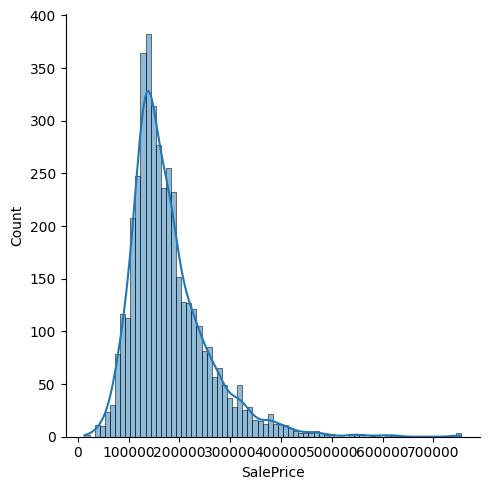

In [13]:
# Target variable distribution
sns.displot(df_train['SalePrice'], kde = True)
plt.show()

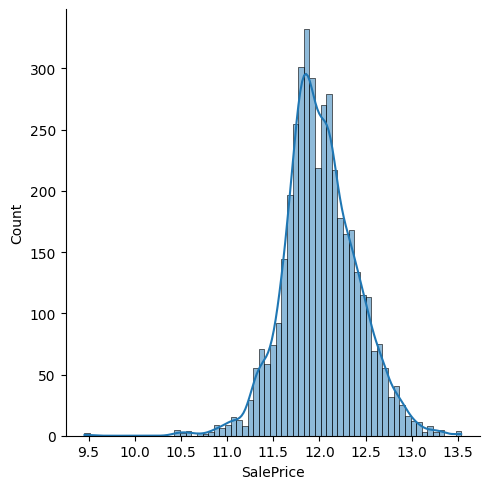

In [14]:
# Log Transform ~ Core logic to normalize skewed target
df_train['SalePrice'] = df_train['SalePrice'].apply(np.log)

# SalePrice Distribution (After Log)
sns.displot(df_train['SalePrice'], kde = True)
plt.show()

In [15]:
# Merge both datasets (excluding target) for uniform preprocessing
all_data = pd.concat([df_train.drop('SalePrice', axis = 1), df_test])

## Data engineering

In this section we will handle missing data, evaluate features with only one category and collapse features with non-frequent values.

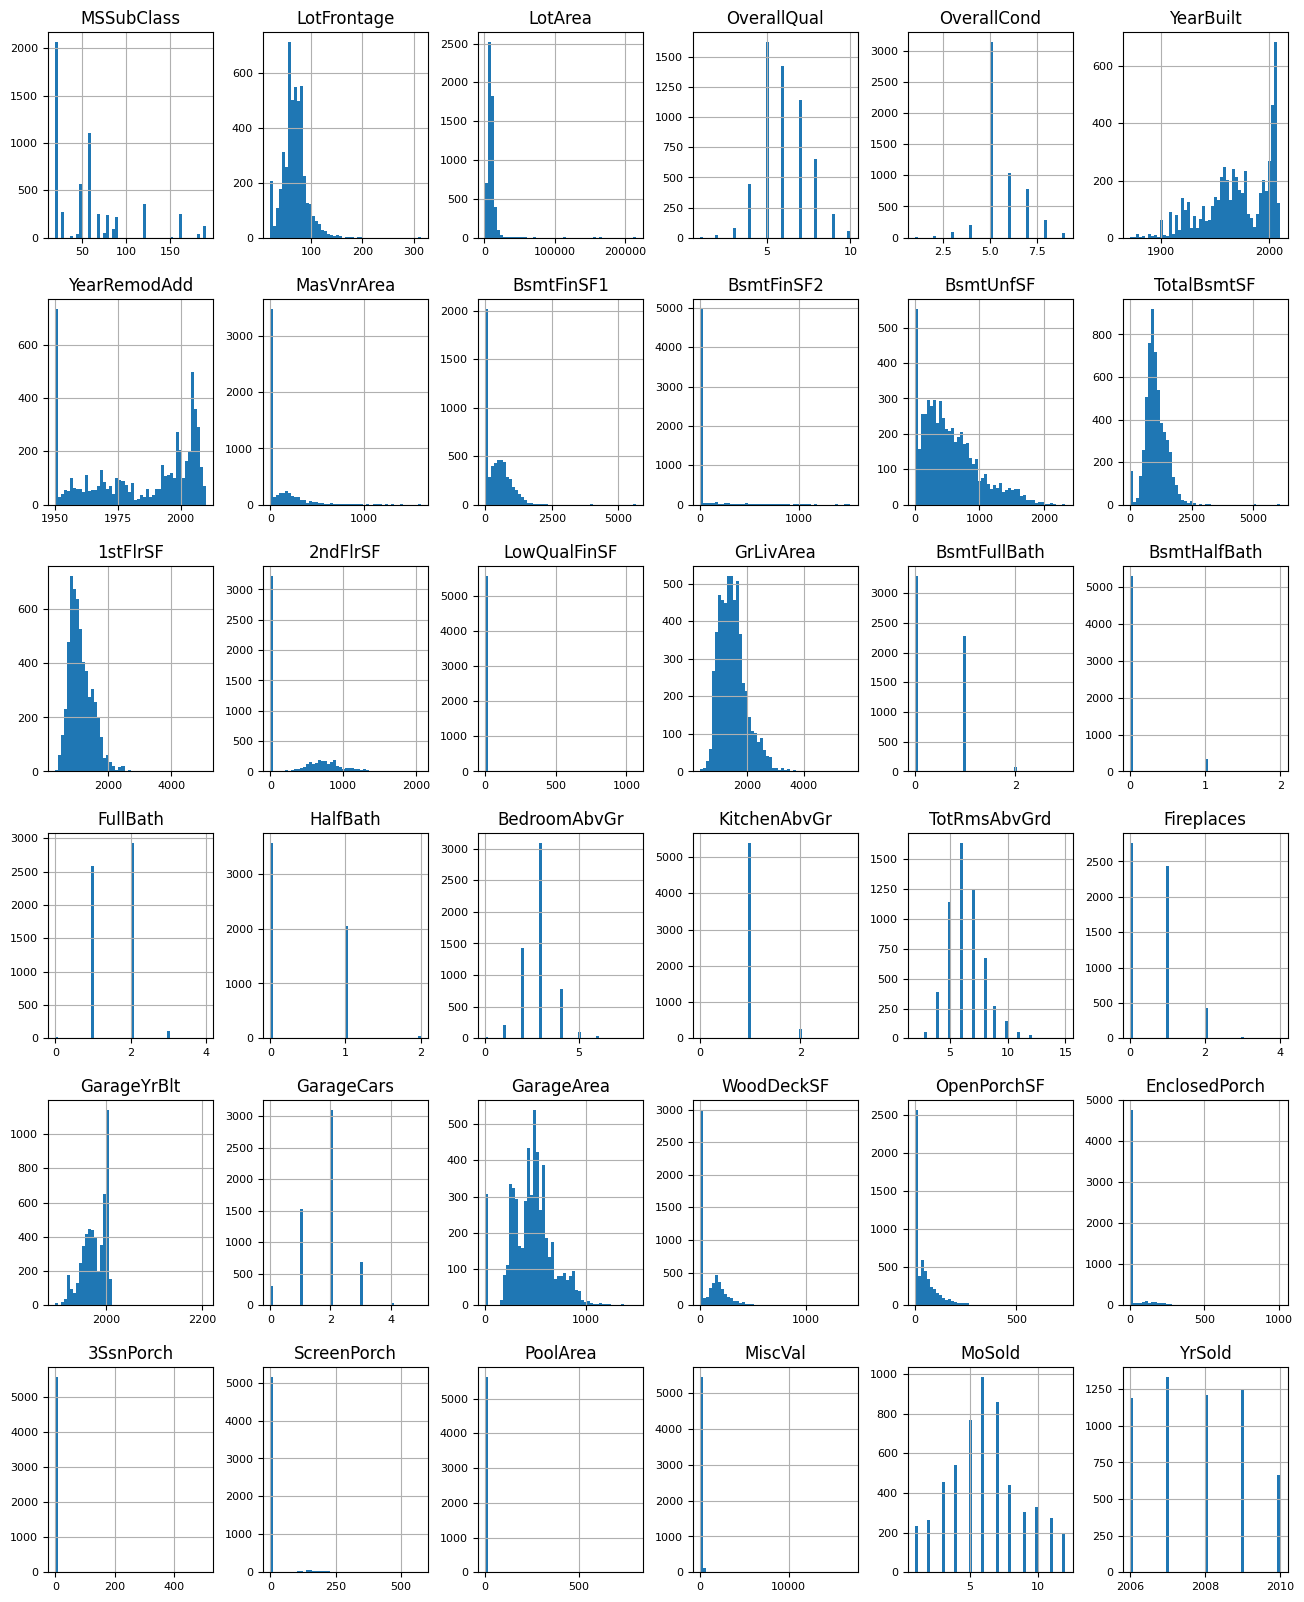

In [17]:
# Distribution of numerical features
df_num = all_data.select_dtypes(include = ['float64', 'int64']).drop('Id', axis = 1)
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Missing Data Detection and Handling

- We will take in consideration the following points:
  - In some datasets there is zero to imply this value is missing, especially in numerical features (instead of `np.nan`)
  - Missing data can be presented as the word `"None"` (instead of `np.nan`)

In [19]:
# Useful EDA function to analyze missingness
def miss_data(data):
    Miss_df = ((data == 0).sum()).to_frame()
    Miss_df = Miss_df.rename(columns = {0: 'zeros'})
    Miss_df.index.name = 'Feature'
    Miss_df['np.nan'] = (data.isnull()).sum()
    Miss_df['None'] = (data == "None").sum()
    Miss_df['total'] = Miss_df['zeros'] + Miss_df['np.nan'] + Miss_df['None']
    Miss_df['Percent'] = 100*Miss_df['total']/len(data)
    Miss_df['Type'] = [data[i].dtype for i in Miss_df.index ]
    return Miss_df.sort_values(ascending = False, by = 'Percent')

In [20]:
# Analyze missing patterns across combined dataset
show_with_scroll(miss_data(data=all_data))

,zeros,np.nan,None,total,Percent,Type
Feature,,,,,,
PoolQC,0,5634,0,5634,99.611033,object
PoolArea,5631,0,0,5631,99.557992,int64
3SsnPorch,5587,0,0,5587,98.780057,int64
LowQualFinSF,5577,0,0,5577,98.603253,int64
MiscVal,5454,0,0,5454,96.428571,int64
MiscFeature,0,5450,0,5450,96.357850,object
BsmtHalfBath,5309,4,0,5313,93.935644,float64
Alley,0,5272,0,5272,93.210750,object
ScreenPorch,5156,0,0,5156,91.159830,int64


By looking at these results we should do:

- **Mean imputation** for:  
  `'BsmtFullBath'`, `'BsmtHalfBath'`, `'BsmtFinSF1'`, `'BsmtFinSF2'`, `'BsmtUnfSF'`, `'TotalBsmtSF'`, `'GarageCars'`, `'GarageArea'`  
  *(in `df_train` and `df_test` separately)*

- **Most frequent imputation** for:  
  `'MasVnrType'`, `'GarageFinish'`, `'GarageQual'`, `'GarageCond'`, `'MSZoning'`, `'Utilities'`, `'Functional'`, `'Exterior2nd'`, `'Exterior1st'`, `'SaleType'`, `'KitchenQual'`  
  *(in `df_train` and `df_test` separately)*

- **Create new features** to be used instead of the original ones that have a lot of zeros:
  - `'Porch' = 'OpenPorchSF' + 'EnclosedPorch' + '3SsnPorch' + 'ScreenPorch'`
  - `'Bath_total' = 'FullBath' + 0.5 * 'HalfBath' + 'BsmtFullBath' + 0.5 * 'BsmtHalfBath'`
  - `'BsmtFinSF' = 'BsmtFinSF1' + 'BsmtFinSF2' - 'BsmtUnfSF'`
  - `'FinSF' = '1stFlrSF' + '2ndFlrSF' - 'LowQualFinSF'`

- **Drop useless features**:
  - `'OpenPorchSF'`, `'EnclosedPorch'`, `'3SsnPorch'`, `'ScreenPorch'`, `'FullBath'`, `'HalfBath'`, `'BsmtFullBath'`, `'BsmtHalfBath'`, `'BsmtFinSF1'`, `'BsmtFinSF2'`, `'BsmtUnfSF'`, `'1stFlrSF'`, `'2ndFlrSF'`, `'LowQualFinSF'`

- **Some features have high percentage of missing values (or zeros) that should be dropped**:
  - `'PoolQC'`, `'PoolArea'`, `'MiscFeature'`, `'MiscVal'`, `'Alley'`, `'Fence'`, `'WoodDeckSF'`, `'FireplaceQu'`, `'Fireplaces'`, `'MasVnrType'`, `'MasVnrArea'`

- **Some features have `np.nan` values, but it should be replaced by `"None"`**:
  - `'BsmtQual'`, `'BsmtCond'`, `'BsmtExposure'`, `'BsmtFinType1'`, `'BsmtFinType2'`, `'GarageType'`, `'GarageFinish'`, `'GarageQual'`, `'GarageCond'`

- **Other zeros have reasons to be zeros**

- **`np.nan` values to be zeros**:
  - `'GarageYrBlt'` should be zeros *(but this feature should be converted to categorical later)*  
  - `'GarageArea'`, `'GarageCars'`

- **`np.nan` values in `'MasVnrArea'` should be zeros**

- `'LotFrontage'` to be imputed using a regression model *(in `df_train` and `df_test` separately)*

In [22]:
# Found columns with missing data
cat_feat = ['GarageFinish', 'GarageQual', 'GarageCond', 'MSZoning',
                  'Utilities', 'Functional', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual']
num_feat = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2',
                  'BsmtFinSF1']

In [23]:
# Impute Missing Values
cat_imputer_train = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_train.loc[:,cat_feat] = cat_imputer_train.fit_transform(df_train.loc[:, cat_feat])
num_imputer_train = SimpleImputer(missing_values= np.nan, strategy = 'mean')
df_train.loc[:, num_feat] = num_imputer_train.fit_transform(df_train.loc[:, num_feat])

cat_imputer_test = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_test.loc[:,cat_feat] = cat_imputer_test.fit_transform(df_test.loc[:, cat_feat])
num_imputer_test = SimpleImputer(missing_values= np.nan, strategy = 'mean')
df_test.loc[:, num_feat] = num_imputer_test.fit_transform(df_test.loc[:, num_feat])

### Feature Engineering
Adding 4 new features

In [25]:
# Combines full/half bathrooms (including basement) into a single numeric value
df_train['Bath_total'] = df_train['FullBath'] + 0.5*df_train['HalfBath'] + df_train['BsmtFullBath'] + 0.5*df_train['BsmtHalfBath']
df_test['Bath_total'] = df_test['FullBath'] + 0.5*df_test['HalfBath'] + df_test['BsmtFullBath'] + 0.5*df_test['BsmtHalfBath']

# Net finished basement area
df_train['BsmtFinSF'] = df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] - df_train['BsmtUnfSF']
df_test['BsmtFinSF'] = df_test['BsmtFinSF1'] + df_test['BsmtFinSF2'] - df_test['BsmtUnfSF']

# Combined Porch Area
df_train['Porch'] = df_train['OpenPorchSF'] + df_train['EnclosedPorch'] + df_train['3SsnPorch'] + df_train['ScreenPorch']
df_test['Porch'] = df_test['OpenPorchSF'] + df_test['EnclosedPorch'] + df_test['3SsnPorch'] + df_test['ScreenPorch']

# Total Finished SF
df_train['FinSF'] = df_train['1stFlrSF'] + df_train['2ndFlrSF'] - df_train['LowQualFinSF']
df_test['FinSF'] = df_test['1stFlrSF'] + df_test['2ndFlrSF'] - df_test['LowQualFinSF']

In [26]:
# Drop Redundant/Low-Impact Columns
cols_to_drop = ['PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal', 'Alley', 'Fence', 'WoodDeckSF',
            'FireplaceQu', 'Fireplaces', 'MasVnrType', 'MasVnrArea',
            'FullBath', 'HalfBath' , 'BsmtFullBath' ,'BsmtHalfBath',
            'BsmtFinSF1' , 'BsmtFinSF2' , 'BsmtUnfSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']

df_train = df_train.drop(cols_to_drop, axis = 1)
df_test = df_test.drop(cols_to_drop, axis = 1)

### Filling Missing Data

In [28]:
# Set Specific NA Columns to 'None'
Cols_to_None = ['BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 
                        'GarageFinish', 'GarageQual', 'GarageCond']

df_train[Cols_to_None] = df_train.loc[:,Cols_to_None].replace(to_replace = np.nan, value = "None", inplace = False)
df_test[Cols_to_None] = df_test.loc[:,Cols_to_None].replace(to_replace = np.nan, value = "None", inplace = False)

# Fill 0 for Garage-Related Numerical Columns
cols_to_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars']
df_train[cols_to_zero] = df_train[cols_to_zero].fillna(0)
df_test[cols_to_zero] = df_test[cols_to_zero].fillna(0)

In [29]:
# Impute LotFrontage in train dataset via XGBoost
df_train_totrain = df_train[df_train['LotFrontage'].isnull() == False]
df_train_totest = df_train[df_train['LotFrontage'].isnull() == True]

reg = XGBRegressor(n_estimators = 5000, learning_rate = 0.01)
reg.fit(df_train_totrain.select_dtypes(exclude = 'object').drop(['LotFrontage', 'SalePrice', 'Id'], axis = 1), 
        df_train_totrain['LotFrontage'], verbose = False)

df_train.loc[df_train['LotFrontage'].isnull(), 'LotFrontage'] = reg.predict(
    df_train_totest.select_dtypes(exclude='object').drop(['LotFrontage', 'SalePrice', 'Id'], axis=1)
)

df_train = pd.concat([df_train_totrain, df_train_totest])

In [30]:
# Impute LotFrontage in test dataset via XGBoost
df_test_totrain = df_test[df_test['LotFrontage'].isnull() == False]
df_test_totest = df_test[df_test['LotFrontage'].isnull() == True]

reg_test = XGBRegressor(n_estimators = 5000, learning_rate = 0.01)
reg_test.fit(df_test_totrain.select_dtypes(exclude = 'object').drop(['LotFrontage', 'Id'], axis = 1), df_test_totrain['LotFrontage'], 
        verbose = False)

df_test.loc[df_test['LotFrontage'].isnull(), 'LotFrontage'] = reg_test.predict(
    df_test[df_test['LotFrontage'].isnull()].select_dtypes(exclude='object').drop(['LotFrontage', 'Id'], axis=1)
)
df_test = pd.concat([df_test_totrain, df_test_totest])

In [31]:
# Sort by Id
df_train = df_train.sort_values('Id', ascending = True)
df_test = df_test.sort_values('Id', ascending = True)

### Drop redundant features
Remove raw columns after engineering replacements.

In [33]:
# Missing data check
show_with_scroll(miss_data(data = df_train))

,zeros,np.nan,None,total,Percent,Type
Feature,,,,,,
Porch,1295,0,0,1295,30.855373,int64
LotFrontage,0,735,0,735,17.512509,float64
GarageYrBlt,232,0,0,232,5.527758,float64
GarageCars,230,0,0,230,5.480105,float64
GarageArea,230,0,0,230,5.480105,float64
GarageType,0,0,230,230,5.480105,object
BsmtFinSF,147,0,0,147,3.502502,float64
BsmtExposure,0,0,119,119,2.835359,object
BsmtFinType2,0,0,117,117,2.787706,object


## Dealing with categorical features

Date features should be converted to be categorical, but first:

  - There are many years present in df_train and not present in df_test and vice versa
  - To convert date features to categorical that will lead to a large number of categories. So, we will collect year features to be every five years as follows.

A categorical feature in train dataset may have unique categories that not in the test dataset or vice versa, so, we should compare unique categories first in both train and test datasets

In [35]:
# Temporal Feature Rounding
date_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
df_train[date_cols] = round(df_train[date_cols]/5)*5
df_test[date_cols] = round(df_test[date_cols]/5)*5

In [36]:
# Drop Less Useful Categorical Columns
cols_to_drop_2 = ['Street', 'LandContour', 'Utilities', 'LandSlope', 'RoofMatl', 'BsmtCond',
                  'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 
                  'GarageCond', 'PavedDrive']

df_train = df_train.drop(cols_to_drop_2, axis = 1)
df_test = df_test.drop(cols_to_drop_2, axis = 1)

# Normalize MSZoning and Neighborhood
df_train['MSZoning'] = df_train['MSZoning'].replace(to_replace=['A (agr)', 'I (all)'], value = 'C (all)', inplace=False)
df_train['Neighborhood'] = df_train['Neighborhood'].replace(to_replace=['Greens', 'GrnHill','Landmrk'], value = 'NAmes', inplace=False)

# Combining two features into one and dropping the earlier ones
df_train['Condition'] = df_train['Condition1'] + '_' + df_train['Condition2']
df_test['Condition'] = df_test['Condition1'] + '_' + df_test['Condition2']
df_train = df_train.drop(['Condition1', 'Condition2'], axis =1)
df_test = df_test.drop(['Condition1', 'Condition2'], axis =1)

In [37]:
# To diagnose category imbalance (rare combinations) in the newly created 'Condition` feature
condition_unique_vaues_totoal = set(df_train['Condition'].unique()).union(set(df_test['Condition'].unique()))
unique_count_train = len(df_train['Condition'].unique())
unique_count_test = len(df_test['Condition'].unique())
print(f"No. of train unique values is: {unique_count_train}")
print(f"No. of test unique values is: {unique_count_test}")

df_count = pd.DataFrame({'Unique': list(condition_unique_vaues_totoal)})
df_count['train_count'] = [len(df_train[df_train['Condition'] == j]) for j in condition_unique_vaues_totoal]
df_count['train_percent'] = (df_count['train_count']/len(df_train)) * 100
df_count['test_count'] = [len(df_test[df_test['Condition'] == j]) for j in condition_unique_vaues_totoal]
df_count['test_percent'] = (df_count['test_count']/len(df_test)) * 100
df_count.sort_values('train_count', ascending = False)

No. of train unique values is: 22
No. of test unique values is: 16


,Unique,train_count,train_percent,test_count,test_percent
2,Norm_Norm,3611,86.037646,1251,85.743660
17,Feedr_Norm,225,5.360972,79,5.414668
0,Artery_Norm,130,3.097451,44,3.015764
18,RRAn_Norm,58,1.381939,19,1.302262
19,PosN_Norm,51,1.215154,18,1.233722
13,RRAe_Norm,37,0.881582,17,1.165182
6,PosA_Norm,25,0.595664,9,0.616861
7,RRAn_Feedr,12,0.285919,4,0.274160
11,RRNn_Norm,10,0.238265,3,0.205620
14,RRNe_Norm,8,0.190612,4,0.274160


In [38]:
# Collapse Rare Condition Values
to_replace_train = [i for i in df_train['Condition'].unique() if df_train['Condition'].value_counts()[i] < 5]
to_replace_test = [i for i in df_test['Condition'].unique() if df_test['Condition'].value_counts()[i] < 5]
df_train['Condition'] = df_train['Condition'].replace(to_replace= to_replace_train, value = 'Other', inplace=False)
df_test['Condition'] = df_test['Condition'].replace(to_replace = to_replace_test, value = 'Other', inplace = False)

df_train['Condition'] = df_train['Condition'].replace(to_replace=['RRAn_Feedr', 'RRNn_Norm', 'RRNe_Norm', 'PosN_PosN', 'Feedr_Feedr']
                                                              , value = 'Other', inplace=False)

In [39]:
# Normalize More Categorical Features
df_train['HouseStyle'] = df_train['HouseStyle'].replace({'2.5Fin': '2.5Unf'})
df_train['Exterior1st'] = df_train['Exterior1st'].replace(['Stone', 'PreCast', 'ImStucc'], 'BrkComm')
df_train['Exterior2nd'] = df_train['Exterior2nd'].replace(['PreCast', 'Other'], 'CBlock')
df_train['BsmtQual'] = df_train['BsmtQual'].replace('Po', 'Fa')
df_train['KitchenQual'] = df_train['KitchenQual'].replace('Po', 'Fa')
df_train['SaleType'] = df_train['SaleType'].replace({'VWD': 'Con', 'WD ': 'WD'})

### Ordinal encoding
Divide the year features by groups of 5 years and check features that have a category with more than 90% of the observations.

In [41]:
# Fix Anomalous Year Values
df_train['YearBuilt'] = df_train['YearBuilt'].replace({1885.0:1890.0, 1870.0:1880.0, 1875.0:1880.0})
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].replace(to_replace= 1905.0, value= 1910.0, inplace = False)
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].replace(to_replace= 2205.0, value= 2005.0, inplace = False)
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].replace(to_replace= 2205.0, value= 2005.0, inplace = False)

In [42]:
# Convert some 'numerical' features such as years to 'categorical'
df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)#Convert 'MSSubClass' feature to categorical instead of numerical
df_train['YearBuilt'] = df_train['YearBuilt'].astype(str)
df_train['YearRemodAdd'] = df_train['YearRemodAdd'].astype(str)
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].astype(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

df_test['MSSubClass'] = df_test['MSSubClass'].astype(str)#Convert 'MSSubClass' feature to categorical instead of numerical
df_test['YearBuilt'] = df_test['YearBuilt'].astype(str)
df_test['YearRemodAdd'] = df_test['YearRemodAdd'].astype(str)
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].astype(str)
df_test['YrSold'] = df_test['YrSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str)

In [43]:
# Print Dominant Categories (≥90%): features that have unique value more than 90%
for i in df_train.select_dtypes(include= 'object').columns:
    Max = max([len(df_train[df_train[i] == j]) for j in df_train[i].unique()])
    Percent = round(100*Max/len(df_train))
    if Percent >= 90:
        print(i)
    else:
        pass

SaleType


### CatBoost encoding
Apply target-based encoding to high-cardinality categorical variables.

In [45]:
# Collapse Rare Condition Values
to_replace_train = [i for i in df_train['Condition'].unique() if df_train['Condition'].value_counts()[i] < 5]
to_replace_test = [i for i in df_test['Condition'].unique() if df_test['Condition'].value_counts()[i] < 5]
df_train['Condition'] = df_train['Condition'].replace(to_replace= to_replace_train, value = 'Other', inplace=False)
df_test['Condition'] = df_test['Condition'].replace(to_replace = to_replace_test, value = 'Other', inplace = False)

df_train['Condition'] = df_train['Condition'].replace(to_replace=['RRAn_Feedr', 'RRNn_Norm', 'RRNe_Norm', 'PosN_PosN', 'Feedr_Feedr']
                                                              , value = 'Other', inplace=False)

In [46]:
# Normalize More Categorical Features
df_train['HouseStyle'] = df_train['HouseStyle'].replace({'2.5Fin': '2.5Unf'})
df_train['Exterior1st'] = df_train['Exterior1st'].replace(['Stone', 'PreCast', 'ImStucc'], 'BrkComm')
df_train['Exterior2nd'] = df_train['Exterior2nd'].replace(['PreCast', 'Other'], 'CBlock')
df_train['BsmtQual'] = df_train['BsmtQual'].replace('Po', 'Fa')
df_train['KitchenQual'] = df_train['KitchenQual'].replace('Po', 'Fa')
df_train['SaleType'] = df_train['SaleType'].replace({'VWD': 'Con', 'WD ': 'WD'})

### Ordinal Encoding

In [48]:
# Applying ordinal encodings
cols_OE = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC'
           , 'KitchenQual', 'GarageFinish']
dic = {'None':0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No': 1, 'Mn': 2, 'Av': 3, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4
       , 'ALQ': 5, 'GLQ': 6, 'RFn': 2, 'Fin': 3, 'N': 1, 'P': 2, 'Y': 3, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4,'Other':1}

df_train[cols_OE] = df_train[cols_OE].replace(dic).astype("Int64")
df_test[cols_OE] = df_test[cols_OE].replace(dic).astype("Int64")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_24708\3496276085.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[cols_OE] = df_train[cols_OE].replace(dic).astype("Int64")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24708\3496276085.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[cols_OE] = df_test[cols_OE].replace(dic).astype("Int64")


## Categorical Encoding

Apply categorical encoding on the remaining categorical features after ordinal encoding

In [50]:
# select all categorical columns for encoding
cols_CE = df_train.select_dtypes(include= 'object').columns
cols_CE

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'GarageYrBlt',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Condition'],
      dtype='object')

## Fit regression model
We train a regression model using XGBoost transforming the categorical variables with CatBoostEncoder.

In [52]:
# Apply catboost encoder
cbe = ce.cat_boost.CatBoostEncoder(a = 1)
cbe.fit(df_train[cols_CE], df_train['SalePrice'])
df_train[cols_CE] = cbe.transform(df_train[cols_CE])
df_test[cols_CE] = cbe.transform(df_test[cols_CE])

In [53]:
# Print Transformed DataFrame
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,YrSold,SaleType,SaleCondition,SalePrice,Id,Bath_total,BsmtFinSF,Porch,FinSF,Condition
0,12.329425,12.076388,65.0,8450,11.914794,11.991942,12.169479,12.032098,12.161408,7,...,12.006284,11.993244,12.006215,12.247694,0,3.5,556.0,61,1710,12.030107
1,12.042812,12.076388,80.0,9600,11.914794,12.018549,12.355473,12.032098,11.985543,6,...,12.036516,11.993244,12.006215,12.109011,1,2.5,694.0,0,1262,11.818231
2,12.329425,12.076388,68.0,11250,12.172900,11.991942,12.169479,12.032098,12.161408,7,...,12.006284,11.993244,12.006215,12.317167,2,3.5,52.0,42,1786,12.030107
3,11.922851,12.076388,60.0,9550,12.172900,12.010626,12.192566,12.032098,12.161408,7,...,12.011531,11.993244,11.747216,11.849398,3,2.0,-324.0,307,1717,12.030107
4,12.329425,12.076388,84.0,14260,12.172900,12.018549,12.668495,12.032098,12.161408,8,...,12.006284,11.993244,12.006215,12.429216,4,3.5,165.0,84,2198,12.030107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,12.017490,12.076388,37.0,7937,12.172900,12.235561,11.961841,12.032098,12.001097,6,...,12.011531,11.993244,12.006215,11.867097,4192,2.0,635.0,0,1003,12.030107
4193,12.042812,12.076388,NaN,8885,12.172900,11.991942,11.961841,12.032098,11.985543,5,...,12.011531,11.993244,12.006215,11.782953,4193,2.0,386.0,0,902,12.030107
4194,11.899945,12.076388,62.0,10441,11.914794,11.991942,11.961841,12.032098,11.827153,5,...,12.011531,11.993244,12.006215,11.790557,4194,1.5,-238.0,32,970,12.030107
4195,12.042812,12.076388,77.0,10010,11.914794,11.991942,11.961841,12.032098,11.985543,5,...,12.011531,11.993244,12.006215,12.043554,4195,2.0,999.0,38,1389,12.030107


In [54]:
# Fit the model
model_xgb = XGBRegressor(
                        n_estimators = 1000,
                        max_depth = 8,
                        subsample = 0.6,
                        #min_child_weight = 60, 
                        learning_rate = 0.1)

# Training the model
model_xgb.fit(df_train.drop(['Id', 'SalePrice'], axis =1), df_train['SalePrice'],
            verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

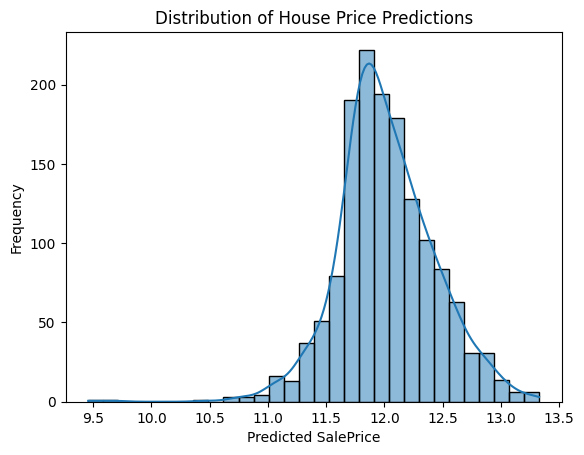

In [55]:
# Generate predictions
preds = model_xgb.predict(df_test.drop('Id', axis = 1))

# Supongamos que tus predicciones están en la variable `y_pred`
sns.histplot(preds, kde=True, bins=30)
plt.title("Distribution of House Price Predictions")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Frequency")
plt.show()

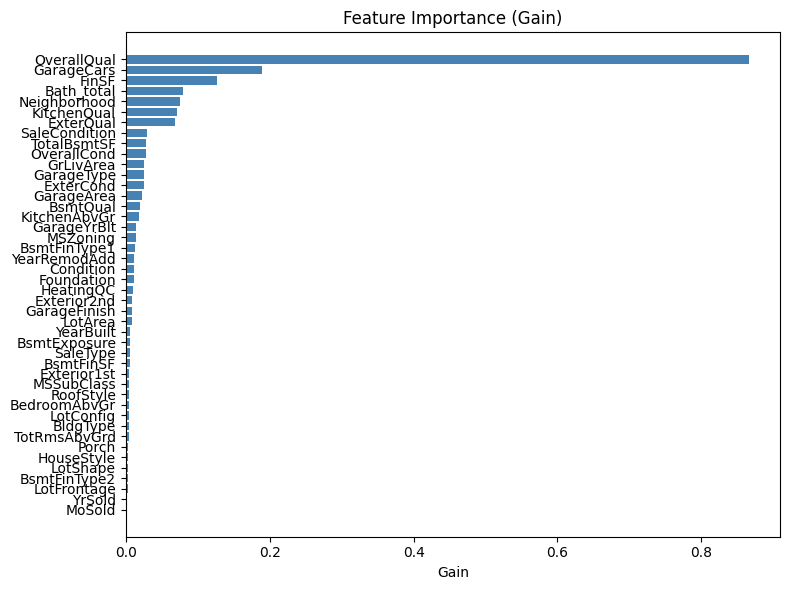

In [106]:
# Plot importance of features
importancia = model_xgb.get_booster().get_score(importance_type='gain')
df_importancia = pd.DataFrame(importancia.items(), columns=['Feature', 'Importance'])
df_importancia = df_importancia.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(df_importancia['Feature'], df_importancia['Importance'], color='steelblue')
plt.title("Feature Importance (Gain)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

In [56]:
# Results to be submitted to kaggle
output = pd.DataFrame({'Id': ids_test,
                       'SalePrice': np.exp(preds)})

path="Submission_XGBoost.csv"
output.to_csv(path, index=False)